# Project 2 Customer Segmentation using RFM Analysis

### Data preprocessing

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
import calendar

In [76]:
df=pd.read_csv('/Users/likitha/Downloads/ecommerce_data.csv',encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [77]:
df["InvoiceDate"]=pd.to_datetime(df["InvoiceDate"])

In [78]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [80]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [81]:
df['InvoiceNo'].nunique()

25900

In [82]:
print("Rows:",df.shape[0],"\nColumns:",df.shape[1])

Rows: 541909 
Columns: 8


In [83]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [84]:
print(df["InvoiceDate"].max(),"\n",df["InvoiceDate"].min())

2011-12-09 12:50:00 
 2010-12-01 08:26:00


### Handling Missing Values

In [85]:
#Description: replacing the null values with a placeholder like "Not mentioned"
df['Description'].fillna('Not mentioned', inplace=True)

In [86]:
#CustomerID: dropping the missing value rows
df.dropna(subset=['CustomerID'], inplace=True)

In [87]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Data Overview Findings : 

##### What is the size of the dataset in terms of the number of rows and columns?
 Initially, there are 541909 rows and 8 columns
##### Can you provide a brief description of each column in the dataset? (change)
 InvoiceNo: Invoice number. A 6 digit number uniquely identifies each transaction.


StockCode: Product code. A  five digit number uniquely identifies each distinct product.


Description: Product name. 


Quantity: The quantities of each product per transaction.


InvoiceDate: The day and time when each transaction is generated.


UnitPrice: A numeric value that infers the product price per unit.


CustomerID: A five digit number uniquely identifies each customer.


Country: Name of the country where each customer resides.

##### What is the time period covered by this dataset?
The time period in the dataset is from 2010-12-01 08:26:00 to 2011-12-09 12:50:00 

### Customer Analysis

In [88]:
# RFM Calculation

recency_df = df.groupby('CustomerID')['InvoiceDate'].max()
recency_df = (pd.to_datetime('today') - recency_df).dt.days

frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique()

monetary_df = df.groupby('CustomerID')['UnitPrice'].sum()

rfm_df = pd.DataFrame({
    'Recency': recency_df,
    'Frequency': frequency_df,
    'Monetary': monetary_df
})

rfm_df

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,4761,2,2.08
12347.0,4437,7,481.21
12348.0,4511,4,178.71
12349.0,4454,1,605.10
12350.0,4745,1,65.30
...,...,...,...
18280.0,4713,1,47.65
18281.0,4616,1,39.36
18282.0,4443,3,62.68


In [89]:
# RFM Segmentation

quartiles = rfm_df[['Recency', 'Frequency', 'Monetary']].quantile([0, 0.25, 0.5, 0.75, 1]).to_dict()

def assign_score(value, metric):
    if value <= quartiles[metric][0.25]:
        return 4
    elif value <= quartiles[metric][0.5]:
        return 3
    elif value <= quartiles[metric][0.75]:
        return 2
    else:
        return 1

rfm_df['Recency_Score'] = rfm_df['Recency'].apply(lambda x: assign_score(x, 'Recency'))
rfm_df['Frequency_Score'] = rfm_df['Frequency'].apply(lambda x: assign_score(x, 'Frequency'))
rfm_df['Monetary_Score'] = rfm_df['Monetary'].apply(lambda x: assign_score(x, 'Monetary'))

#RFM score for each customer
rfm_df['RFM_Score'] = rfm_df['Recency_Score'].astype(str) + rfm_df['Frequency_Score'].astype(str) + rfm_df['Monetary_Score'].astype(str)
rfm_df

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
CustomerID,,,,,,,
12346.0,4761,2,2.08,1,3,4,134
12347.0,4437,7,481.21,4,1,1,411
12348.0,4511,4,178.71,2,2,2,222
12349.0,4454,1,605.10,3,4,1,341
12350.0,4745,1,65.30,1,4,3,143
...,...,...,...,...,...,...,...
18280.0,4713,1,47.65,1,4,4,144
18281.0,4616,1,39.36,1,4,4,144
18282.0,4443,3,62.68,4,3,3,433


In [90]:
g=rfm_df['RFM_Score'].value_counts()
print(g)

411    461
144    357
244    199
311    196
143    193
      ... 
241      4
214      3
314      2
441      1
114      1
Name: RFM_Score, Length: 64, dtype: int64


In [91]:
# Customer Analysis

unique_customers = rfm_df.index.nunique()
print("Number of Unique Customers:", unique_customers)

Number of Unique Customers: 4372


In [92]:
orders_per_customer= rfm_df['Frequency'].value_counts()
print("\nDistribution of Orders per Customer:\n", orders_per_customer)


Distribution of Orders per Customer:
 1     1313
2      817
3      490
4      377
5      288
      ... 
60       1
81       1
50       1
40       1
62       1
Name: Frequency, Length: 65, dtype: int64


In [93]:
top_5_customers = rfm_df.nlargest(5, 'Frequency')
print("\nTop 5 Customers by Order Count:\n", top_5_customers)


Top 5 Customers by Order Count:
             Recency  Frequency  Monetary  Recency_Score  Frequency_Score  \
CustomerID                                                                 
14911.0        4436        248  31060.66              4                1   
12748.0        4436        224  15115.60              4                1   
17841.0        4437        169  20333.18              4                1   
14606.0        4436        128   7839.02              4                1   
13089.0        4438        118   5166.45              4                1   

            Monetary_Score RFM_Score  
CustomerID                            
14911.0                  1       411  
12748.0                  1       411  
17841.0                  1       411  
14606.0                  1       411  
13089.0                  1       411  


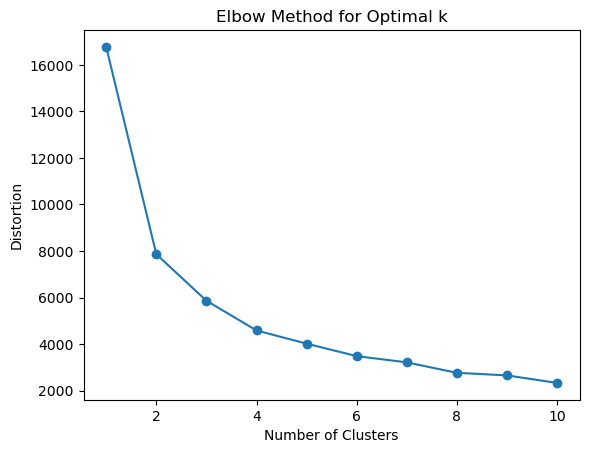

Number of clusters chosen: 3
Number of customers in each cluster:
2    1831
1    1620
0     921
Name: Cluster, dtype: int64


In [94]:
rfm_data = rfm_df[['Recency_Score', 'Frequency_Score', 'Monetary_Score']].astype(float)

def find_optimal_clusters(data, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()


find_optimal_clusters(rfm_data)
optimal_clusters = 3

kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_data)

print("Number of clusters chosen:", optimal_clusters)
print("Number of customers in each cluster:")
print(rfm_df['Cluster'].value_counts())


Segment Profiles:
   Cluster      Recency  Frequency    Monetary
0        0  4458.374593   2.209555   97.127211
1        1  4468.287654  10.455556  710.551222
2        2  4613.901693   1.756963   91.355993


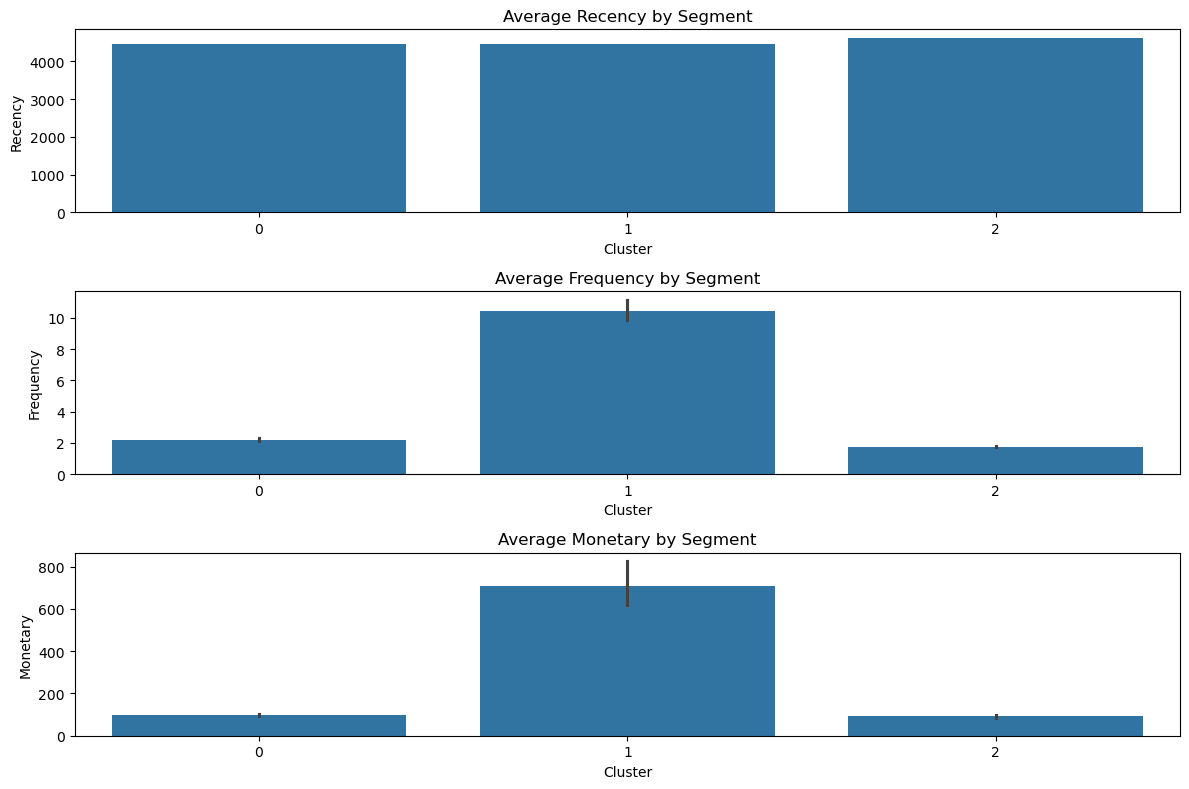

In [95]:
# Visualization of  RFM scores across segments

segment_profiles = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).reset_index()

print("Segment Profiles:")
print(segment_profiles)


plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
sns.barplot(x='Cluster', y='Recency', data=rfm_df, estimator='mean')
plt.title('Average Recency by Segment')

plt.subplot(3, 1, 2)
sns.barplot(x='Cluster', y='Frequency', data=rfm_df, estimator='mean')
plt.title('Average Frequency by Segment')

plt.subplot(3, 1, 3)
sns.barplot(x='Cluster', y='Monetary', data=rfm_df, estimator='mean')
plt.title('Average Monetary by Segment')

plt.tight_layout()
plt.show()


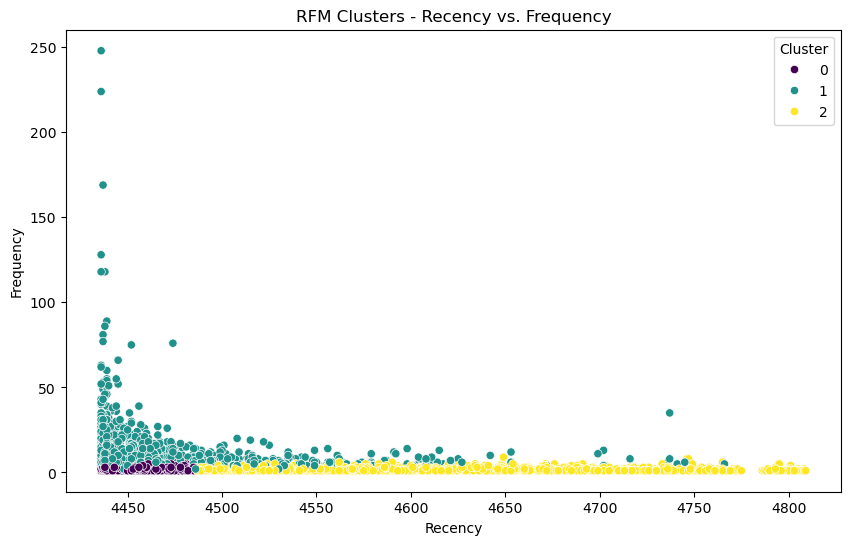

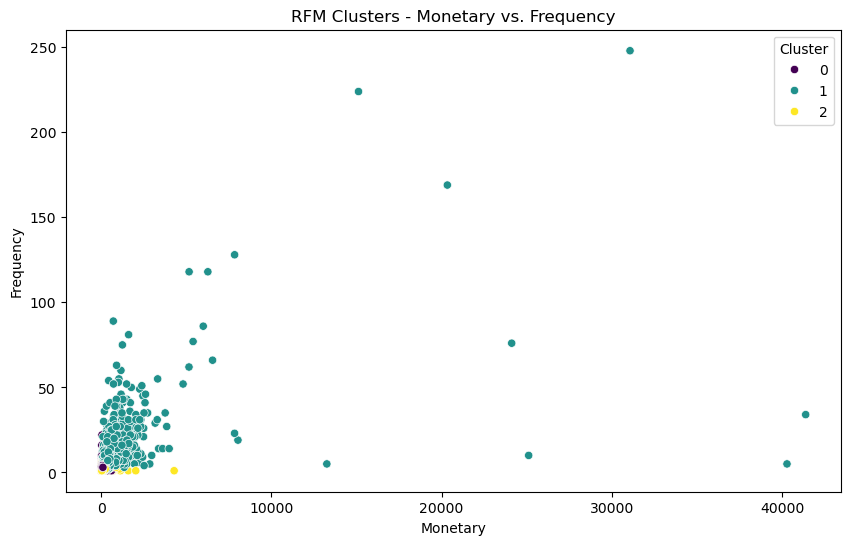

In [96]:
# RFM Distribution Visualization

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm_df, palette='viridis')
plt.title('RFM Clusters - Recency vs. Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Monetary', y='Frequency', hue='Cluster', data=rfm_df, palette='viridis')
plt.title('RFM Clusters - Monetary vs. Frequency')
plt.show()

### Product Analysis

In [97]:
# Product Analysis 

df = pd.merge(df, rfm_df['RFM_Score'], left_on='CustomerID', right_index=True)

In [98]:
#Top 10 most frequently purchased products across all RFM segments
top_10_products_across_segments = df.groupby('Description')['Quantity'].sum().nlargest(10)
print("\nTop 10 Most Frequently Purchased Products Across All RFM Segments:\n", top_10_products_across_segments)


Top 10 Most Frequently Purchased Products Across All RFM Segments:
 Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53215
JUMBO BAG RED RETROSPOT               45066
ASSORTED COLOUR BIRD ORNAMENT         35314
WHITE HANGING HEART T-LIGHT HOLDER    34147
PACK OF 72 RETROSPOT CAKE CASES       33409
POPCORN HOLDER                        30504
RABBIT NIGHT LIGHT                    27094
MINI PAINT SET VINTAGE                25880
PACK OF 12 LONDON TISSUES             25321
PACK OF 60 PINK PAISLEY CAKE CASES    24163
Name: Quantity, dtype: int64


In [99]:
#Average price of products across all RFM segments
average_price_across_segments = df.groupby('RFM_Score')['UnitPrice'].mean()
print("\nAverage Price of Products Across All RFM Segments:\n", average_price_across_segments)


Average Price of Products Across All RFM Segments:
 RFM_Score
111     3.368566
112     3.349076
113     3.550909
114     3.271667
121    22.072588
         ...    
434     1.942540
441     3.693354
442     2.378326
443     2.419362
444     2.196745
Name: UnitPrice, Length: 64, dtype: float64


In [100]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df = pd.merge(df, rfm_df['RFM_Score'], left_on='CustomerID', right_index=True)

#Product category generating the highest revenue across all RFM segments
highest_revenue_category = df.groupby('Description')['Revenue'].sum().idxmax()
print("\nProduct Category Generating the Highest Revenue Across All RFM Segments:\n",highest_revenue_category)


Product Category Generating the Highest Revenue Across All RFM Segments:
 REGENCY CAKESTAND 3 TIER


### Time Analysis

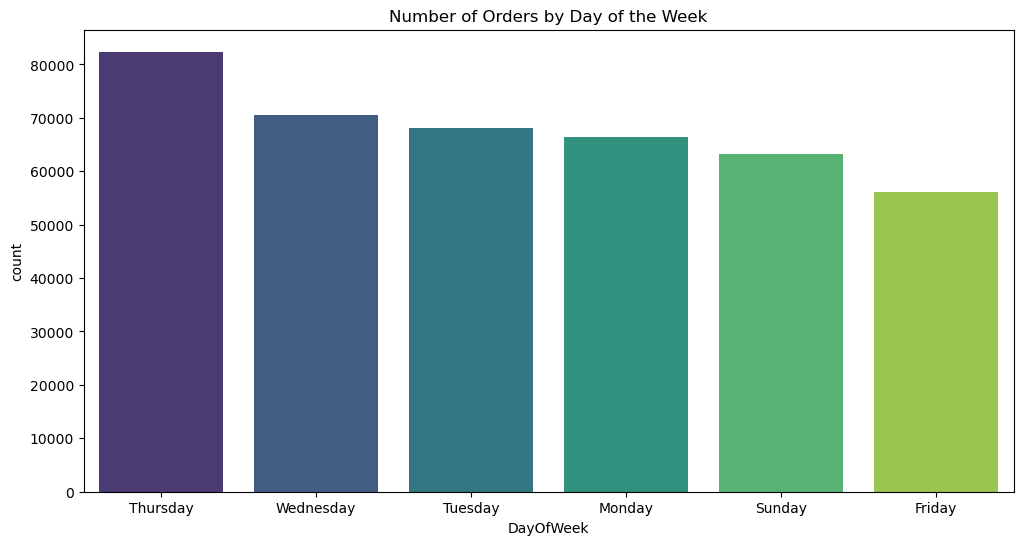

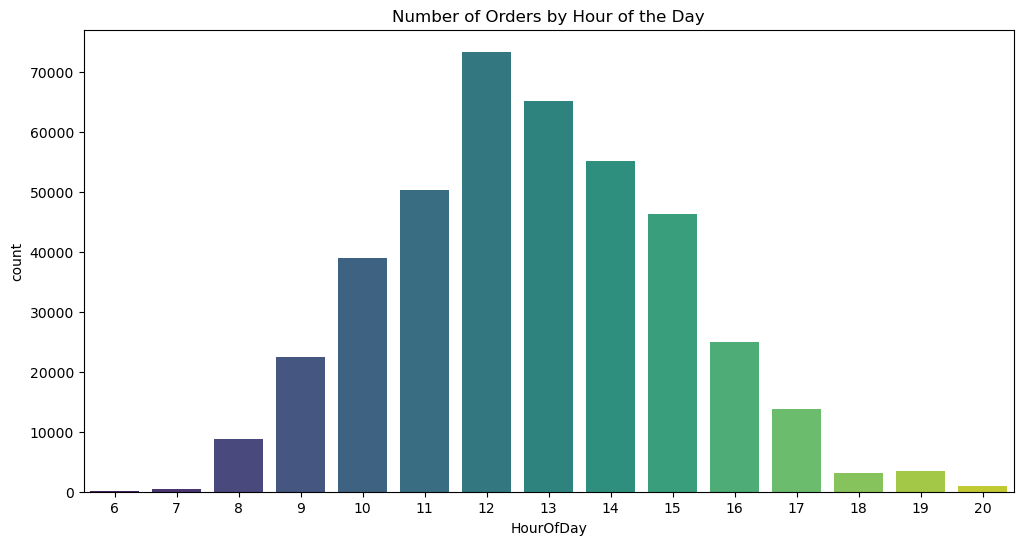

In [101]:
#To identify if there's a specific day of the week or time of day when most orders are placed

df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['HourOfDay'] = df['InvoiceDate'].dt.hour

# Visualizing the number of orders by day of the week
plt.figure(figsize=(12, 6))
sns.countplot(x='DayOfWeek', data=df, order=df['DayOfWeek'].value_counts().index, palette='viridis')
plt.title('Number of Orders by Day of the Week')
plt.show()

# Visualizing the number of orders by hour of the day
plt.figure(figsize=(12, 6))
sns.countplot(x='HourOfDay', data=df, palette='viridis')
plt.title('Number of Orders by Hour of the Day')
plt.show()


According to the above, highest orders are placed on Thursdays in a week and at around 12pm every day. 

In [102]:
# Average order processing time
average_order_processing_time=(df['InvoiceDate']-df['InvoiceDate'].shift()).mean()
average_order_processing_time

Timedelta('0 days 00:01:19.249707493')

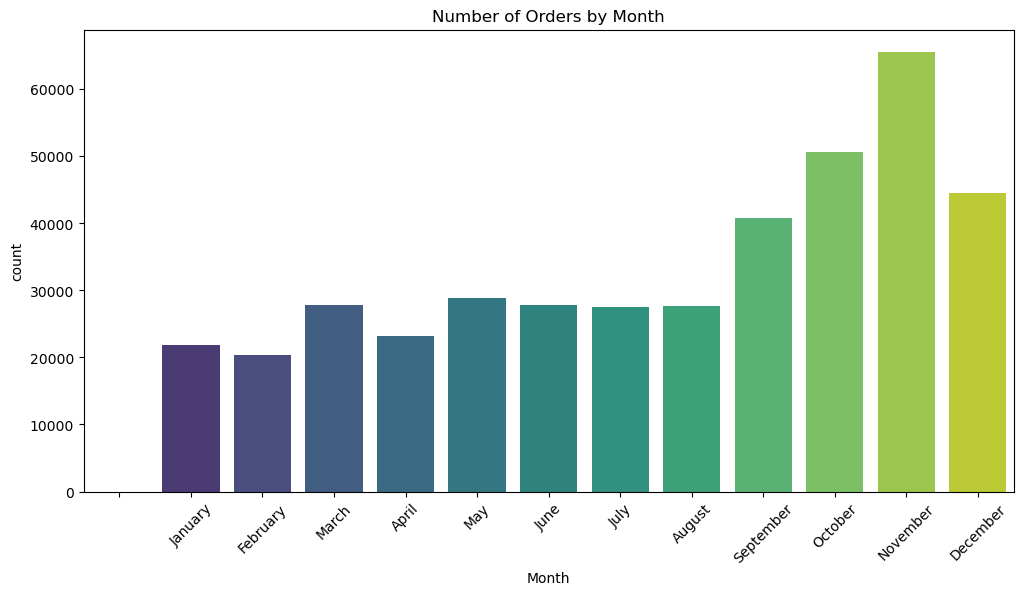

In [103]:
#Seasonal trends

df['Month'] = df['InvoiceDate'].dt.month_name()

plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=df, palette='viridis', order=calendar.month_name)
plt.title('Number of Orders by Month')
plt.xticks(rotation=45)
plt.show()


Maximum number of orders are placed in the month of November followed by October.

### Geographical Analysis

In [104]:
top_5_countries = df['Country'].value_counts().nlargest(5)
top_5_countries

United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Spain               2533
Name: Country, dtype: int64

In [105]:
#Correlation between Country and Average Order Value
avg_order_value_by_country = df.groupby('Country')['UnitPrice'].mean()
correlation = avg_order_value_by_country.corr(df.groupby('Country')['UnitPrice'].count())

print(f'Correlation between Country and Average Order Value: {correlation:.2f}')


Correlation between Country and Average Order Value: -0.04


Correlation coeeficient is -0.04, this indicates that there is little to no correlation between the country and the average order value. The negative sign indicates that, on average, there is a slight tendency for the average order value to decrease as the country changes, but this relationship is not strong.

### Payment Analysis

- The dataset does not provide information about the payment methods used by the customers. Hence it can't be analysed.

### Customer Behaviour


In [106]:
# Calculate average customer lifespan

customer_lifespan = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
customer_lifespan['Lifespan'] = (customer_lifespan['max'] - customer_lifespan['min']).dt.days
average_lifespan = customer_lifespan['Lifespan'].mean()

print(f'Average Customer Lifespan: {average_lifespan:.2f} days')


Average Customer Lifespan: 133.39 days


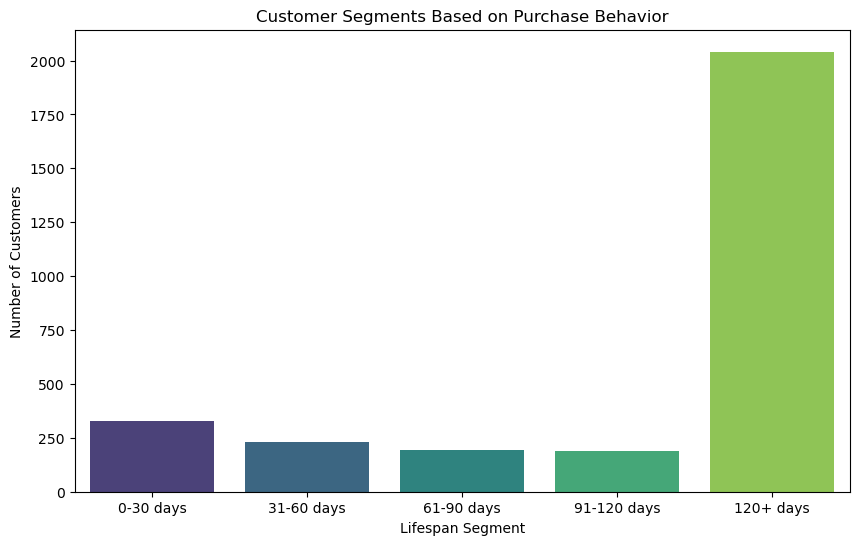

In [107]:
#Distribution of customer segments

bins = [0, 30, 60, 90, 120, float('inf')]
labels = ['0-30 days', '31-60 days', '61-90 days', '91-120 days', '120+ days']
customer_lifespan['Segment'] = pd.cut(customer_lifespan['Lifespan'], bins=bins, labels=labels)


plt.figure(figsize=(10, 6))
sns.countplot(x='Segment', data=customer_lifespan, palette='viridis')
plt.title('Customer Segments Based on Purchase Behavior')
plt.xlabel('Lifespan Segment')
plt.ylabel('Number of Customers')
plt.show()


Aroung 300 customers make purchases very frequently, with a short time span between each purchase. (0-30 days) where as aroung 2k customers have not made a purchase in a long time, indicating potential inactivity.(120+ days)

### Returns and Refunds

- The dataset does not provide information about the returns or refunds initiated by the customers. Hence it can't be analysed.

### Profitability Analysis

In [109]:
# Calculate total profit

start_date = '2010-12-01 08:26:00'
end_date = '2011-12-09 12:50:00'

filtered_df = df[(df['InvoiceDate'] >= start_date) & (df['InvoiceDate'] <= end_date)]
filtered_df['Revenue'] = filtered_df['Quantity'] * filtered_df['UnitPrice']
filtered_df['TotalCost'] = filtered_df['Revenue'] * (1 - 0.2)

total_revenue = filtered_df['Revenue'].sum()
total_cost = filtered_df['TotalCost'].sum()
total_profit = total_revenue - total_cost

print(f'Total Profit for the dataset time period: ${total_profit:.2f}')


Total Profit for the dataset time period: $1660013.16


In [111]:
#Top 5 products with the highest profit margins

df['ProfitMargin'] = ((filtered_df['Revenue'] - filtered_df['TotalCost']) / filtered_df['Revenue']) * 100

top_products_profit_margin = df.groupby('Description')['ProfitMargin'].mean().nlargest(5)

print('Top 5 Products with Highest Profit Margins:')
print(top_products_profit_margin)

Top 5 Products with Highest Profit Margins:
Description
BLUE EGG  SPOON                       20.0
BLUE PUDDING SPOON                    20.0
BROCANTE SHELF WITH HOOKS             20.0
DISCO BALL CHRISTMAS DECORATION       20.0
FOLDING CAMPING SCISSOR W/KNIF & S    20.0
Name: ProfitMargin, dtype: float64


### Customer Satisfaction

- The dataset does not provide information about the feedback given by the customers. Hence it can't be analysed.